In [2]:
import urllib
from IPython.display import Markdown as md
_nb_loc = "04_detect_segment/04b_unet_segmentation.ipynb" # change to reflect your notebook
_nb_title = "Modified U-Net on Pets dataset" # change to reflect your notebook
_nb_message = "This notebook illustrates a modified U-Net on the Oxford Pets dataset. It uses a pre-trained MobileNet for the encoder, and upsampling Keras layers for the decoder. It's based heavily on the TensorFlow tutorial https://www.tensorflow.org/tutorials/images/segmentation" # change to reflect your notebook
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))


<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Modified+U-Net+on+Pets+dataset&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F04_detect_segment%2F04b_unet_segmentation.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_detect_segment/04b_unet_segmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_detect_segment/04b_unet_segmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/04_detect_segment/04b_unet_segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>Modified U-Net on Pets dataset</h1>This notebook illustrates a modified U-Net on the Oxford Pets dataset. It uses a pre-trained MobileNet for the encoder, and upsampling Keras layers for the decoder. It's based heavily on the TensorFlow tutorial https://www.tensorflow.org/tutorials/images/segmentation

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.4.1
Found GPU at: /device:GPU:0


## Read Oxford-IIIT Pets dataset

The dataset is part of TensorFlow datasets.
Version 3 and higher of the dataset has ground truth
segmentation masks.

The dataset already contains test and train splits.

In [2]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXSI85B/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXSI85B/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


When loading an image, we do the following:
* Resize the image and mask to 128x128
* Scale the image to [0,1]
* Create input_mask labels. The original segmentation mask consists of {1,2,3} for background, outline, and interior respectively. We subtract 1 to get class indexes of {0,1,2}.



In [14]:
def read_and_preprocess(data):
  input_image = tf.image.resize(data['image'], (128, 128))
  input_mask = tf.image.resize(data['segmentation_mask'], (128, 128))
  
  input_image = tf.image.convert_image_dtype(input_image, tf.float32) # [0,1]
  input_mask -= 1 # {1,2,3} to {0,1,2}

  return input_image, input_mask

In [15]:
train = dataset['train'].map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(read_and_preprocess)

## Display some example images and their labels

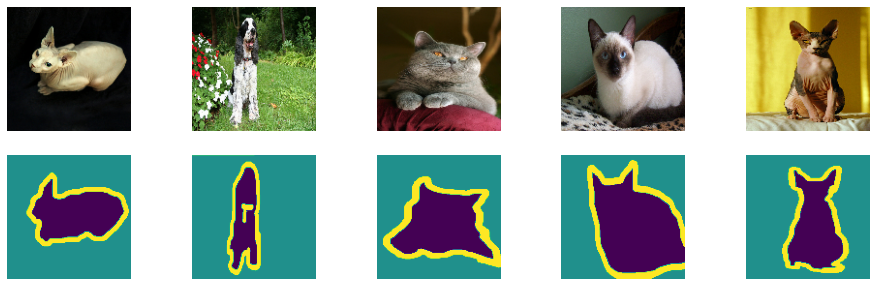

In [23]:
import matplotlib.pylab as plt
import numpy as np
f, ax = plt.subplots(2, 5, figsize=(16,5))
for idx, (img, mask) in enumerate(train.take(5)):
  ax[0, idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
  ax[0, idx].axis('off')
  mask = tf.reshape(mask, [128, 128])
  ax[1, idx].imshow(mask.numpy())
  ax[1, idx].axis('off')

## Modified U-Net
The model being used here is a modified [U-Net](https://link.springer.com/content/pdf/10.1007%2F978-3-319-24574-4_28.pdf).
A U-Net typically consists of an encoder 
which downsamples an image to an encoding,
and a mirrored decoder which upsamples the encoding
back to the desired mask. The decoder blocks have a number of skip connections
that directly connect the encoder blocks to the decoder.

Doing this from scratch requires a lot of trainable parameters and is better done using Generative
Adversarial Networks (GANs) which are covered in
Chapter 12. 

In this notebook, we will use a pretrained MobileNetV2 to
create the encoding and a set of upsampling layers to
get back to the desired mask. 
When doing so, however, we will pull out layers with the
desired sizes so that the upsampling skip layers use
corresponding weights from the pretrained models.

Note that the output consists of 3 channels. This is because we have 3 possible labels for each pixel (background, outline, interior). Think of this as multi-classification problem with three possible classes.

In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [25]:
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS = 3

In [41]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers to form skip connections
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs,
                            name='pretrained_mobilenet')

down_stack.trainable = False

The decoder/upsampler is a series of upsample blocks.
Conv2DTranspose is what does the upsampling.
We also add batchnorm and relu.

In [42]:
def upsample(filters, size, name):
  return tf.keras.Sequential([
     tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.ReLU()
  ], name=name)

up_stack = [
    upsample(512, 3, 'upsample_4x4_to_8x8'),
    upsample(256, 3, 'upsample_8x8_to_16x16'),
    upsample(128, 3, 'upsample_16x16_to_32x32'),
    upsample(64, 3,  'upsample_32x32_to_64x64')
]

In [68]:
import re

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for idx, (up, skip) in enumerate(zip(up_stack, skips)):
    x = up(x)
    concat = tf.keras.layers.Concatenate(name='expand_{}'.format(idx))
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

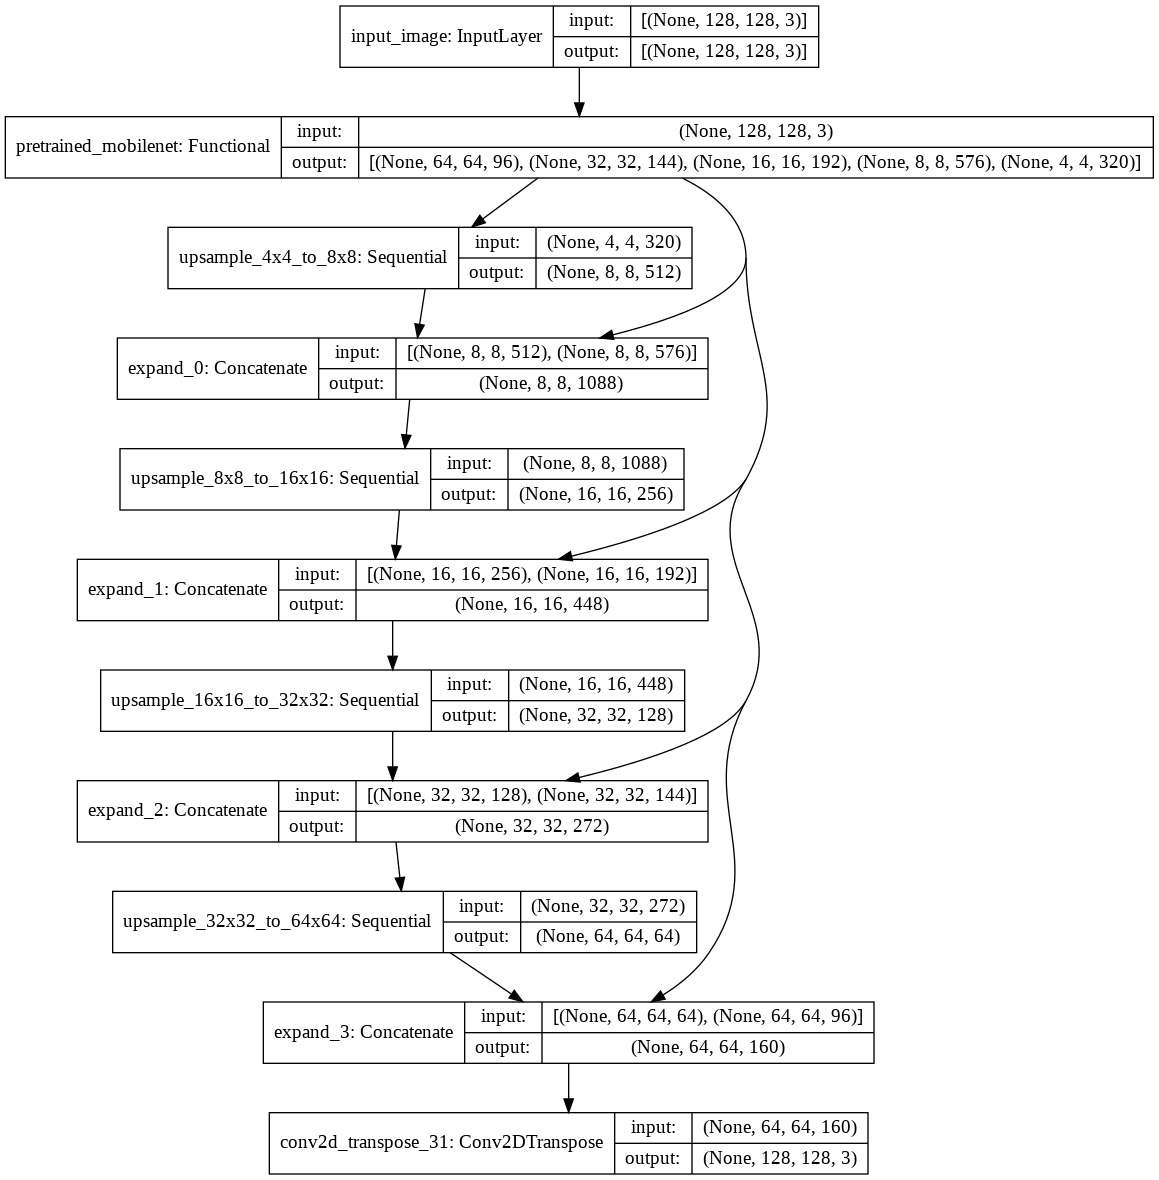

In [72]:
model = unet_model(OUTPUT_CHANNELS)
tf.keras.utils.plot_model(model, show_shapes=True)

## Train the model

We treat this as a multi-class prediction problem.
So, the loss function used is SparseCategoricalCrossentropy
and the metric is accuracy.

In [80]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
# Assign to the pixel the label with the highest probability
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

Helper functions to see model output as it is training

In [75]:
# display helper functions
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def show_predictions(dataset, num):
  for image, mask in dataset.take(num):
    pred_mask = model.predict(image)
    display([image[0], mask[0], create_mask(pred_mask)])

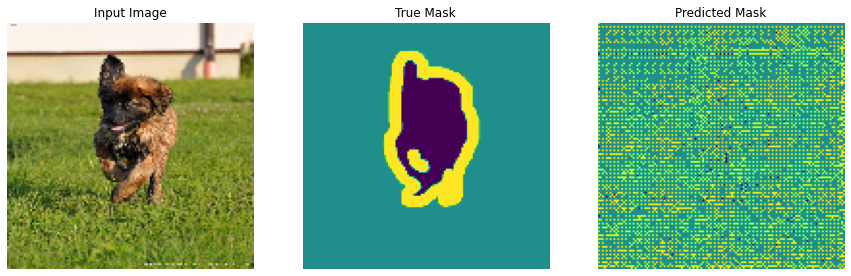

In [76]:
# before the model is trained
show_predictions(test_dataset, 1)

To observe how the model improves while it is training we define a callback function to show the predictions when the epoch finishes.

In [88]:
# from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch%5 == 0:
      # clear_output(wait=True) # if you want replace the images each time, uncomment this
      show_predictions(test_dataset, 1)
      print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
57/57 [==============================] - 9s 154ms/step - loss: 0.4832 - accuracy: 0.7981 - val_loss: 0.5452 - val_accuracy: 0.7749


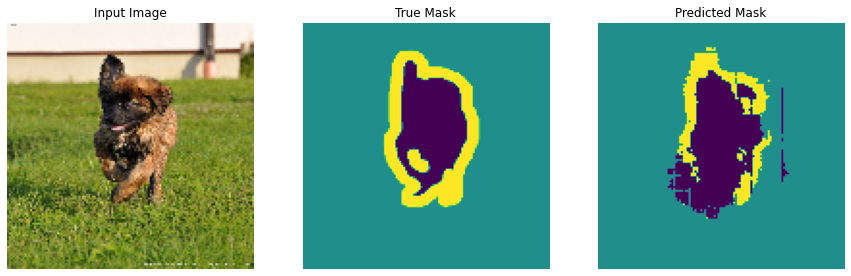


Sample Prediction after epoch 1

Epoch 2/20
57/57 [==============================] - 9s 157ms/step - loss: 0.4788 - accuracy: 0.7997 - val_loss: 0.5391 - val_accuracy: 0.7773
Epoch 3/20
57/57 [==============================] - 9s 156ms/step - loss: 0.4687 - accuracy: 0.8043 - val_loss: 0.5376 - val_accuracy: 0.7775
Epoch 4/20
57/57 [==============================] - 9s 156ms/step - loss: 0.4674 - accuracy: 0.8047 - val_loss: 0.6278 - val_accuracy: 0.7517
Epoch 5/20
57/57 [==============================] - 9s 156ms/step - loss: 0.4597 - accuracy: 0.8078 - val_loss: 0.5496 - val_accuracy: 0.7766
Epoch 6/20
57/57 [==============================] - 9s 155ms/step - loss: 0.4506 - accuracy: 0.8113 - val_loss: 0.5620 - val_accuracy: 0.7714


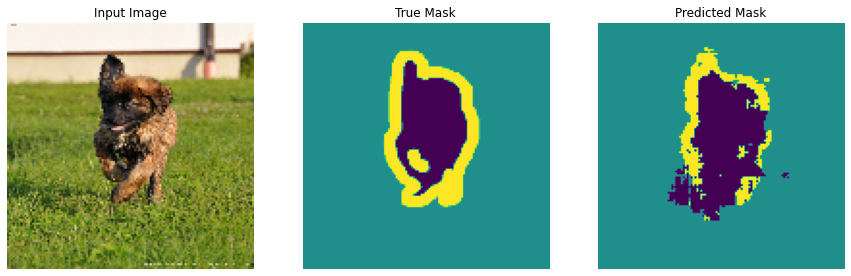


Sample Prediction after epoch 6

Epoch 7/20
57/57 [==============================] - 9s 155ms/step - loss: 0.4447 - accuracy: 0.8140 - val_loss: 0.5861 - val_accuracy: 0.7635
Epoch 8/20
57/57 [==============================] - 9s 155ms/step - loss: 0.4388 - accuracy: 0.8159 - val_loss: 0.6019 - val_accuracy: 0.7617
Epoch 9/20
57/57 [==============================] - 9s 155ms/step - loss: 0.4287 - accuracy: 0.8202 - val_loss: 0.5471 - val_accuracy: 0.7778
Epoch 10/20
57/57 [==============================] - 9s 155ms/step - loss: 0.4172 - accuracy: 0.8252 - val_loss: 0.5641 - val_accuracy: 0.7755
Epoch 11/20
57/57 [==============================] - 9s 155ms/step - loss: 0.4223 - accuracy: 0.8223 - val_loss: 0.6064 - val_accuracy: 0.7726


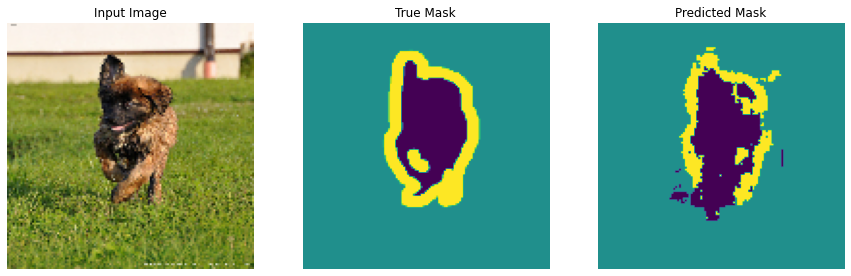


Sample Prediction after epoch 11

Epoch 12/20
57/57 [==============================] - 9s 155ms/step - loss: 0.4043 - accuracy: 0.8301 - val_loss: 0.5892 - val_accuracy: 0.7744
Epoch 13/20
57/57 [==============================] - 9s 157ms/step - loss: 0.3944 - accuracy: 0.8340 - val_loss: 0.6057 - val_accuracy: 0.7722
Epoch 14/20
57/57 [==============================] - 9s 156ms/step - loss: 0.3892 - accuracy: 0.8361 - val_loss: 0.5866 - val_accuracy: 0.7772
Epoch 15/20
57/57 [==============================] - 9s 156ms/step - loss: 0.3789 - accuracy: 0.8403 - val_loss: 0.6204 - val_accuracy: 0.7669
Epoch 16/20
57/57 [==============================] - 9s 156ms/step - loss: 0.3698 - accuracy: 0.8439 - val_loss: 0.6417 - val_accuracy: 0.7700


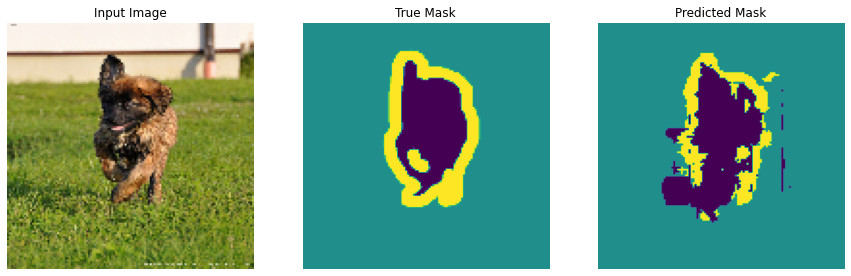


Sample Prediction after epoch 16

Epoch 17/20
57/57 [==============================] - 9s 156ms/step - loss: 0.3656 - accuracy: 0.8456 - val_loss: 0.6171 - val_accuracy: 0.7706
Epoch 18/20
57/57 [==============================] - 9s 155ms/step - loss: 0.3527 - accuracy: 0.8508 - val_loss: 0.6466 - val_accuracy: 0.7699
Epoch 19/20
57/57 [==============================] - 9s 155ms/step - loss: 0.3474 - accuracy: 0.8528 - val_loss: 0.6197 - val_accuracy: 0.7739
Epoch 20/20
57/57 [==============================] - 9s 156ms/step - loss: 0.3317 - accuracy: 0.8593 - val_loss: 0.6525 - val_accuracy: 0.7717


In [89]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

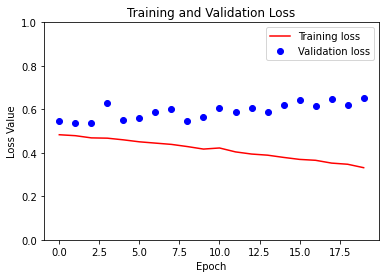

In [91]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

To improve the performance further:
* Add data augmentation (Chapter 6)
* Use region proposal networks (next notebook)

## License

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook is based on https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb which is also licensed under Apache 2
